In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"



import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random
from nrmifactors import algorithm as algo
from nrmifactors.state import State
import nrmifactors.priors as priors

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


/opt/homebrew/Caskroom/miniconda/base/envs/scipy-dev/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import logging
logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()

logger.addFilter(CheckTypesFilter())

In [37]:
from scipy.stats import skewnorm

ndata = 50
ngroups = 100

key = random.PRNGKey(202204)

locs = np.array([-2.0, 0.0, 2.0])
data = []
probs = []

for i in range(ngroups):
    key, subkey = random.split(key)
    probas = tfd.Dirichlet(np.array([0.5, 0.5, 0.5])).sample(seed=subkey)
    probs.append(probas)
    key, subkey = random.split(key)
    clus = tfd.Categorical(probs=probas).sample((ndata), seed=subkey)
    key, subkey = random.split(key)
    curr = tfd.Normal(locs[clus], np.ones_like(clus) * 1.5).sample(seed=subkey)
    data.append(curr)

data = np.stack(data)

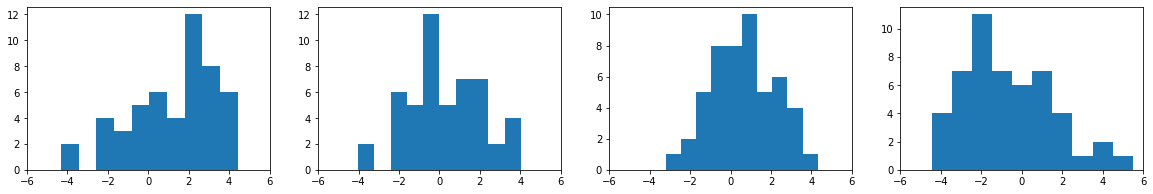

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 3))
axes[0].hist(onp.array(data[0, :]))    
axes[1].hist(onp.array(data[2, :]))
axes[2].hist(onp.array(data[5, :]))    
axes[3].hist(onp.array(data[-2, :]))

for i in range(4):
    axes[i].set_xlim(-6, 6)

In [39]:
from sklearn.cluster import KMeans

natoms = 10

# initialize stuff
# init_atoms = np.hstack([
#    tfd.Normal(loc=0, scale=10).sample(natoms, seed=key).reshape(-1, 1),
#    np.ones((natoms, 1))
# ])

km = KMeans(natoms)
km.fit(data.reshape(-1, 1))
clus = km.predict(data.reshape(-1,1)).reshape(data.shape)
means = km.cluster_centers_

init_atoms = np.hstack([means, np.ones_like(means) * 0.3])

In [40]:
init_atoms

DeviceArray([[ 4.54083071,  0.3       ],
             [-0.34425466,  0.3       ],
             [-3.21876325,  0.3       ],
             [ 2.19803801,  0.3       ],
             [-2.16579456,  0.3       ],
             [ 1.3286652 ,  0.3       ],
             [-1.2458734 ,  0.3       ],
             [-4.62266529,  0.3       ],
             [ 3.16572857,  0.3       ],
             [ 0.5128749 ,  0.3       ]], dtype=float64)

In [67]:
#init_atoms = np.hstack([means.reshape(-1, 1), np.ones_like(means).reshape(-1, 1) * 1])
#natoms = init_atoms.shape[0]

key = random.PRNGKey(202204)
nlat = 20

prior = priors.NrmiFacPrior(
    kern_prior=priors.NNIGPrior(0.0, 0.01, 5.0, 5.0),
    lam_prior_iid=priors.GammaPrior(4.0, 4.0),
    lam_prior_mgp=priors.MGPPrior(50.0, 2.0, 3.0, 0, -0.05, 0.05),
    lam_prior="mgp",
    m_prior=priors.GammaPrior(2.0, 2.0),
    j_prior=priors.GammaPrior(2.0, 2.0)
)


lam = np.ones((ngroups, nlat)) / nlat
m = tfd.Gamma(0.1, 2.0).sample((nlat, natoms), seed=key).astype(float)

j = np.ones(natoms).astype(float) * 0.5
u = np.ones(ngroups).astype(float)

#clus = tfd.Categorical(probs=np.ones(natoms)/natoms).sample(data.shape, seed=key)
state = State(
    iter=0,
    atoms=init_atoms, 
    j=j, 
    lam=lam,
    phis=1.0/lam,
    deltas=np.ones(lam.shape[1]),
    m=m, 
    clus=clus, 
    u=u,
)
nan_idx = np.where(np.isnan(data))
nobs_by_group = np.array(
        [np.count_nonzero(~np.isnan(x)) for x in data]).astype(float)

In [68]:
key = random.PRNGKey(202204)

In [69]:
state, key = algo.adapt_mgp(state, 1000, 50, data, nan_idx, nobs_by_group, prior, key)

50/1000 removing col, snew shape:  (100, 14)
100/1000 removing col, snew shape:  (100, 13)
150/1000 removing col, snew shape:  (100, 4)
200/1000  removing col, snew shape:  (100, 3)
250/1000 adding column
300/1000 adding column
350/1000 removing col, snew shape:  (100, 4)
400/1000 adding column
450/1000 adding column
500/1000 adding column
550/1000 removing col, snew shape:  (100, 6)
600/1000 removing col, snew shape:  (100, 4)
650/1000 adding column
700/1000 removing col, snew shape:  (100, 4)
750/1000 adding column
800/1000 removing col, snew shape:  (100, 4)
850/1000 adding column
900/1000 removing col, snew shape:  (100, 4)
950/1000 removing col, snew shape:  (100, 3)
1000/1000 adding column


In [71]:
from copy import deepcopy

niter = 60000
nburn = 50000
thin = 1

states = []

for i in range(niter):
    print("\r{0}/{1}".format(i+1, niter), flush=True, end=" ")
    state, key = algo.run_one_step(state, data, nan_idx, nobs_by_group, prior, key)
    if (i > nburn) and (i % thin == 0):
        states.append(deepcopy(state))

60000/60000 

In [72]:
import pickle

with open("simu2/chains_mgp3.pickle", "wb") as fp:
    pickle.dump(states, fp)

In [73]:
def eval_densities(xgrid, lam, m, j, atoms):
    weights = np.matmul(lam, m) * j
    weights /= weights.sum(axis=1)[:, np.newaxis]
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    dens = np.sum(dens, axis=-1).T
    return dens

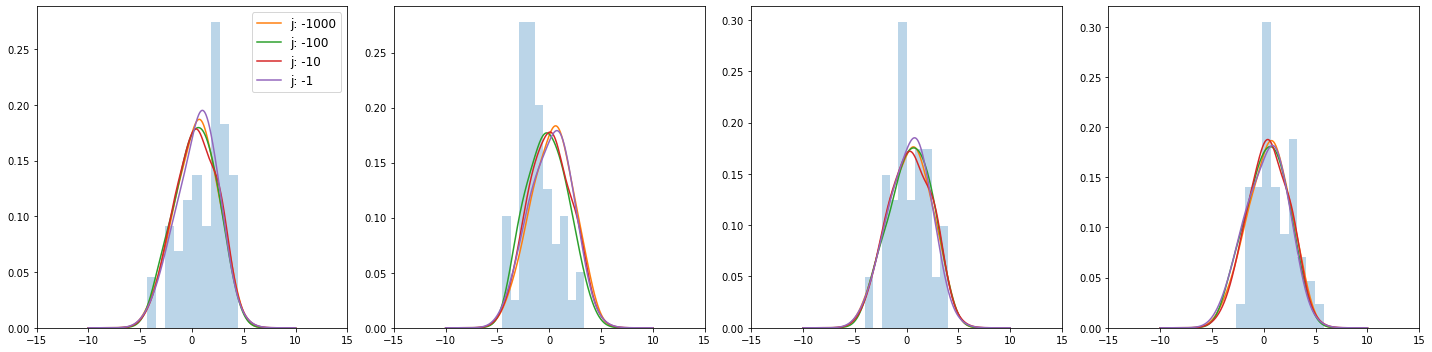

In [76]:
group_idx = [0, 1, 2, 4]

fig, axes = plt.subplots(nrows=1, ncols=len(group_idx), figsize=(20, 5))


idx = [-1, -10, -100, -1000]
xgrid = np.linspace(-10, 10, 1000)



for i in range(len(group_idx)):
    axes[i].hist(onp.array(data[group_idx[i], :]), density=True, alpha=0.3)

for j in sorted(idx):
    state = states[j]
    dens = eval_densities(xgrid, state.lam, state.m, state.j, state.atoms)
    for i in range(len(group_idx)):
        axes[i].plot(xgrid, dens[group_idx[i], :], label="j: {0}".format(j))
        axes[i].set_xlim(-15, 15)
        
axes[0].legend(fontsize=12)   
plt.tight_layout()
# plt.savefig("simu1/dens_estimate.pdf", bbox_inches="tight")        
plt.show()

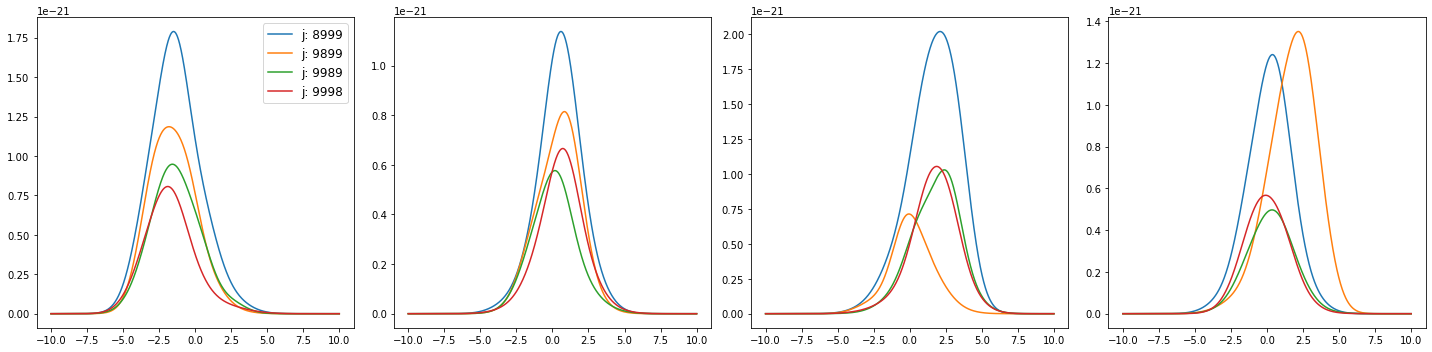

In [77]:
nlat = states[-1].lam.shape[1]

fig, axes = plt.subplots(nrows=1, ncols=int(nlat), figsize=(20, 5))
axes = axes.flat

for j in sorted(idx):
    state = states[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T    


    for i in range(nlat):
        axes[i].plot(xgrid, dens_lat[i, :], label="j: {0}".format(len(states) + j))
        
axes[0].legend(fontsize=12)

plt.tight_layout()
plt.show()

In [80]:
states[-1].j

array([8.19008149e-22, 4.39867483e-22, 4.27171770e-22, 4.91014455e-22,
       9.28752625e-22, 7.49530899e-22, 3.92672799e-22, 5.29230925e-22,
       4.08704742e-22, 1.19683519e-21])

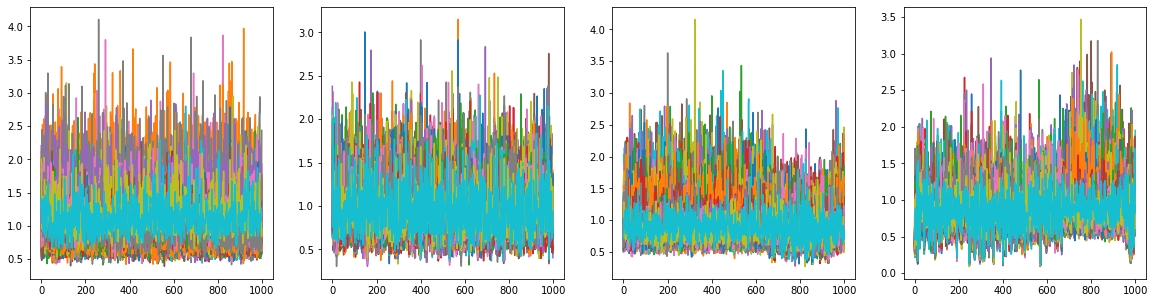

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(20,5))

axes = axes.flat

for i in range(ngroups):
    for j in range(nlat):
        axes[j].plot([x.lam[i, j] for x in states[-1000:]], label="j: {0}".format(j + 1))

In [89]:
states[0].u

array([5.74883848e+18, 5.18233398e+18, 6.20061805e+18, 6.99941780e+18,
       6.52379691e+18, 5.29482495e+18, 7.04711118e+18, 4.75986217e+18,
       3.50346204e+18, 6.24075088e+18, 6.47866680e+18, 6.34633680e+18,
       5.65733565e+18, 8.30400515e+18, 6.38049368e+18, 7.68915370e+18,
       4.81843781e+18, 8.95363674e+18, 5.41398475e+18, 6.34554202e+18,
       5.13599458e+18, 4.57578033e+18, 6.06141648e+18, 5.84603469e+18,
       6.72494294e+18, 9.67284444e+18, 4.86911541e+18, 4.65537176e+18,
       9.17128392e+18, 6.66491118e+18, 7.02303100e+18, 6.18530236e+18,
       4.86945536e+18, 8.44220055e+18, 4.45116442e+18, 6.20153884e+18,
       5.78542867e+18, 5.37312027e+18, 5.47503624e+18, 5.72316042e+18,
       5.80791689e+18, 5.19445560e+18, 7.35153418e+18, 5.72338022e+18,
       4.35989073e+18, 3.70152292e+18, 6.47269195e+18, 5.65360446e+18,
       7.97862767e+18, 4.86242735e+18, 5.44832981e+18, 8.16809274e+18,
       5.58776447e+18, 5.26059897e+18, 6.03345029e+18, 5.91073991e+18,
      

# PostProcess

In [16]:
import pickle

# with open("simu2/chains_mgp2.pickle", "rb") as fp:
#    states = pickle.load(fp)

In [203]:
from jax import jit
from jax import jacfwd, grad
from nrmifactors.postprocess import ralm

delta = xgrid[1] - xgrid[0]

@jit
def obj_func(x, J, M, component_dens):
    curr_m = x @ M
    trans_dens = curr_m * J @ component_dens
    trans_dens /= (np.sum(trans_dens, axis=1, keepdims=True) * delta)
    out = 0.0
    for i in range(trans_dens.shape[0]):
        for j in range(i):
            curr = (np.sum((trans_dens[i, :] * trans_dens[j, :]) **2 ) * delta)
            out += curr
    return out

@jit
def obj_func2(x, J, M, component_dens):
    curr_m = x @ M
    trans_dens = curr_m * J @ component_dens
    trans_dens /= (np.sum(trans_dens, axis=1, keepdims=True) * delta)
    out = 0.0
    for i in range(trans_dens.shape[0]):
        for j in range(i):
            curr = np.sum(np.sqrt(trans_dens[i, :] * trans_dens[j, :])) * delta
            out += curr
    return out

@jit
def constraints(x):
    return - np.concatenate([
        (lam @ np.linalg.inv(x)).reshape(-1, 1),
        (x @ M).reshape(-1, 1)])[:, 0]

@jit
def max0(x):
    return x * (x > 0)

@jit
def penalty(x, lambdas):
    return 0.5 * 1.0 * np.sum(max0(lambdas / 0.5 + constraints(x))**2)


stepsize = 1e-6
init_thr = 1e-2
target_thr = 1e-6
min_lambda = 1e-4
init_lambdas = np.zeros_like(constr_eval) + 1
dmin = 1e-6
init_lambdas = np.zeros_like(constr_eval) + 0.01
max_lambda = 2
init_rho = 1
mu = 0.5


def get_opt_q(state, init_point):
    M = state.m
    lam = state.lam
    J = state.j 
    J /= np.sum(J)
    xgrid = np.linspace(-6, 6, 1000)

    component_dens = np.array([
        tfd.Normal(x[0], np.sqrt(x[1])).prob(xgrid) for x in states[0].atoms])
    
    f = lambda x: obj_func2(x, J, M, component_dens)
    grad_f = grad(f)
    grad_cons = jacfwd(constraints)
    
    opt_x_pen = ralm(
        f, grad_f, constraints, grad_cons, init_point, mu, stepsize, 
        init_thr, target_thr, init_lambdas, min_lambda, max_lambda, 
        init_rho, dmin, maxiter=100)
    return opt_x_pen

In [204]:
q0 = get_opt_q(states[0], np.eye(M.shape[0]))

Init Loss:  5.0325306994132895
Loss: 5.031125072883535, step: 40.00001125546129, eps: 0.01
max(lambdas) :  0.0001
Loss: 5.02835611769026, step: 0.0006748723662078649, eps: 0.009000000000000001
max(lambdas) :  0.0001
Loss: 5.0255319406339165, step: 0.0006815392257805586, eps: 0.008100000000000001
max(lambdas) :  0.0001
Loss: 5.0226488869582, step: 0.0006885790887283062, eps: 0.007290000000000001
max(lambdas) :  0.0001
Loss: 5.019702818987654, step: 0.0006960378819134515, eps: 0.006561000000000002
max(lambdas) :  0.0001
Loss: 5.016689014029911, step: 0.0007039708533830963, eps: 0.005904900000000002
max(lambdas) :  0.0001
Loss: 5.0136020310352984, step: 0.0007124453500525478, eps: 0.005314410000000002
max(lambdas) :  0.0001
Loss: 5.010435532879928, step: 0.000721544742505069, eps: 0.004782969000000002
max(lambdas) :  0.0001
Loss: 5.007182043767725, step: 0.0007313741331357342, eps: 0.004304672100000002
max(lambdas) :  0.0001
Loss: 5.003832608433369, step: 0.000742068950303711, eps: 0.0038

In [208]:
state = states[0]
M = state.m
lam = state.lam
J = state.j 
J /= np.sum(J)
xgrid = np.linspace(-6, 6, 1000)

component_dens = np.array([
    tfd.Normal(x[0], np.sqrt(x[1])).prob(xgrid) for x in states[0].atoms])

obj_func2(q0, J, M, component_dens)

DeviceArray(nan, dtype=float64)

In [210]:
curr_m = q0 @ M
trans_dens = curr_m * J @ component_dens
trans_dens /= (np.sum(trans_dens, axis=1, keepdims=True) * delta)


In [218]:
out = 0.0
for i in range(trans_dens.shape[0]):
    for j in range(i):
        curr = np.sum(np.sqrt(trans_dens[i, :] * trans_dens[j, :])) * delta
        print(i, j, curr)
        out += curr

1 0 nan
2 0 nan
2 1 0.8783178273619314
3 0 nan
3 1 0.9926028686230352
3 2 0.8267242179461508


In [220]:
i = 1
j = 0

trans_dens[i, :] * trans_dens[j, :]

DeviceArray([ 1.81597780e-06,  1.89453864e-06,  1.97629512e-06,
              2.06136890e-06,  2.14988595e-06,  2.24197670e-06,
              2.33777619e-06,  2.43742420e-06,  2.54106546e-06,
              2.64884973e-06,  2.76093205e-06,  2.87747284e-06,
              2.99863811e-06,  3.12459966e-06,  3.25553521e-06,
              3.39162863e-06,  3.53307016e-06,  3.68005653e-06,
              3.83279128e-06,  3.99148487e-06,  4.15635498e-06,
              4.32762669e-06,  4.50553273e-06,  4.69031374e-06,
              4.88221848e-06,  5.08150411e-06,  5.28843645e-06,
              5.50329024e-06,  5.72634945e-06,  5.95790750e-06,
              6.19826762e-06,  6.44774311e-06,  6.70665768e-06,
              6.97534572e-06,  7.25415269e-06,  7.54343541e-06,
              7.84356241e-06,  8.15491431e-06,  8.47788415e-06,
              8.81287777e-06,  9.16031424e-06,  9.52062617e-06,
              9.89426019e-06,  1.02816773e-05,  1.06833534e-05,
              1.10997795e-05,  1.1531462

In [202]:
qs = [get_opt_q(x, q0) for x in onp.array(states)[np.arange(0, 10000, 10)]]

Init Loss:  nan
Loss: nan, step: 40.0, eps: 0.01
max(lambdas) :  0.01705467185450245
Loss: nan, step: 0.0, eps: 0.009000000000000001
max(lambdas) :  0.02340387652355465
Loss: nan, step: 0.0, eps: 0.008100000000000001
max(lambdas) :  0.029118160725701635
Loss: nan, step: 0.0, eps: 0.007290000000000001
max(lambdas) :  0.03426101650763392
Loss: nan, step: 0.0, eps: 0.006561000000000002
max(lambdas) :  0.03888958671137298
Loss: nan, step: 0.0, eps: 0.005904900000000002
max(lambdas) :  0.04305529989473813
Loss: nan, step: 0.0, eps: 0.005314410000000002
max(lambdas) :  0.046804441759766766
Loss: nan, step: 0.0, eps: 0.004782969000000002
max(lambdas) :  0.050178669438292536
Loss: nan, step: 0.0, eps: 0.004304672100000002
max(lambdas) :  0.05321547434896573
Loss: nan, step: 0.0, eps: 0.003874204890000002
max(lambdas) :  0.055948598768571604
Loss: nan, step: 0.0, eps: 0.003486784401000002
max(lambdas) :  0.058408410746216895
Loss: nan, step: 0.0, eps: 0.003138105960900002
max(lambdas) :  0.0606

Loss: 5.011153343188803, step: 39.99996770723664, eps: 0.01
max(lambdas) :  0.01816917841965927
Loss: 5.005978742802918, step: 0.0012159388776350325, eps: 0.009000000000000001
max(lambdas) :  0.02716005011009276
Loss: 5.000638448759017, step: 0.00123512847818697, eps: 0.008100000000000001
max(lambdas) :  0.036757734093449755
Loss: 4.995116112590318, step: 0.0012558756492672368, eps: 0.007290000000000001
max(lambdas) :  0.04678175213177746
Loss: 4.989391983405836, step: 0.0012784836760896747, eps: 0.006561000000000002
max(lambdas) :  0.057081602618116234
Loss: 4.9834416609689365, step: 0.0013033643557638335, eps: 0.005904900000000002
max(lambdas) :  0.06753294976943114
Loss: 4.9772341229921375, step: 0.001331099715693093, eps: 0.005314410000000002
max(lambdas) :  0.0780343974954867
Loss: 4.970728385114122, step: 0.0013625567460512596, eps: 0.004782969000000002
max(lambdas) :  0.08850486120451065
Loss: 4.963867223790939, step: 0.0013991375414908402, eps: 0.004304672100000002
max(lambdas)

Loss: 5.024593475744853, step: 40.00003111933213, eps: 0.01
max(lambdas) :  0.018403749679953042
Loss: 5.019791474332867, step: 0.0011717206003844126, eps: 0.009000000000000001
max(lambdas) :  0.027819927935705778
Loss: 5.014838393295737, step: 0.001189904685816662, eps: 0.008100000000000001
max(lambdas) :  0.03799553797088706
Loss: 5.0097184411723505, step: 0.001209673876352261, eps: 0.007290000000000001
max(lambdas) :  0.04871769710313915
Loss: 5.004411958027088, step: 0.0012314000973311983, eps: 0.006561000000000002
max(lambdas) :  0.05980855896174838
Loss: 4.998893539382402, step: 0.0012556351890344434, eps: 0.005904900000000002
max(lambdas) :  0.07112100538355708
Loss: 4.993128494564233, step: 0.0012832705391746626, eps: 0.005314410000000002
max(lambdas) :  0.082535158616036
Loss: 4.987064844335578, step: 0.0013159657717622824, eps: 0.004782969000000002
max(lambdas) :  0.09395601927354172
Loss: 4.980606798643338, step: 0.0013579336677017018, eps: 0.004304672100000002
max(lambdas) 

KeyboardInterrupt: 

In [110]:
with open("simu2/chains_mgp3_qs_newloss.pickle", "wb") as fp:
    pickle.dump(qs, fp)

In [82]:


x0 = np.eye(M.shape[0])

grad_f = grad(obj_func)
f = obj_func
constr_eval = constraints(x0)
grad_cons = jacfwd(constraints)
stepsize = 1e-6
init_thr = 1e-2
target_thr = 1e-6
min_lambda = 1e-4
init_lambdas = np.zeros_like(constr_eval) + 1
max_lambda = 20
init_rho = 1
dmin = 1e-6

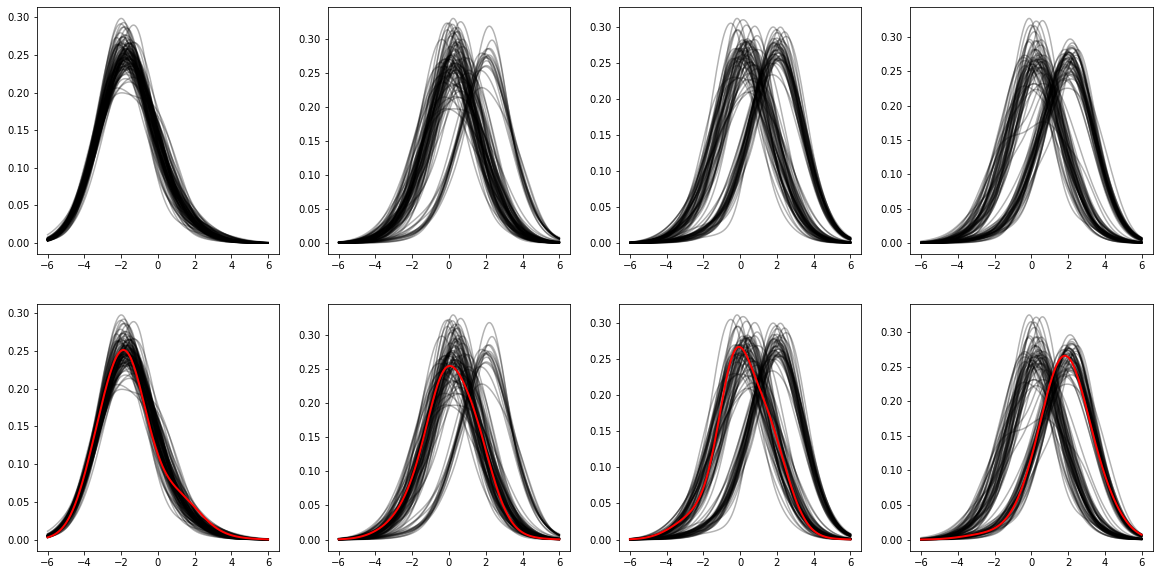

In [113]:
from scipy.integrate import trapz


idx = np.arange(1, 1000, 10)

fig, axes = plt.subplots(nrows=2, ncols=int(nlat), figsize=(20, 10))

for j in sorted(idx):
    state = onp.array(states)[np.arange(0, 10000, 10)][j]
    q = qs[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T   


    for i in range(nlat):
        d = dens_lat[i, :]
        d = d / np.sum(d * delta)
        axes[0][i].plot(xgrid, d, color="black", alpha=0.3)
    
    
    dens_lat = eval_comps[:, np.newaxis, :] * (q @ state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T   


    for i in range(nlat):
        d = dens_lat[i, :]
        d = d / np.sum(d * delta)
        if j == sorted(idx)[-1]:
            axes[1][i].plot(xgrid, d, color="red", lw=2)
        else:
            axes[1][i].plot(xgrid, d, color="black", alpha=0.3)

In [180]:
from jax import vmap

def distmat(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """distance matrix"""
    return vmap(lambda x1: vmap(lambda y1: np.sum((x1 - y1)**2))(y))(x)


def align(template_dens, dens_lat):    
    dists = distmat(template_dens, dens_lat)
    out = []
    for i in range(template_dens.shape[0]):
        best = np.argmin(dists[i, :])
        out.append(dens_lat[best, :])
        dists = dists.at[:, best].set(1000)
        
    return np.stack(out)

In [131]:
state = states[-1]
eval_comps = tfd.Normal(
    loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    
dens_lat = eval_comps[:, np.newaxis, :] * (q @ state.m * state.j)[np.newaxis, :, :]
dens_lat = np.sum(dens_lat, axis=-1).T   
template_dens = dens_lat / (np.sum(dens_lat, axis=1, keepdims=True) * delta)

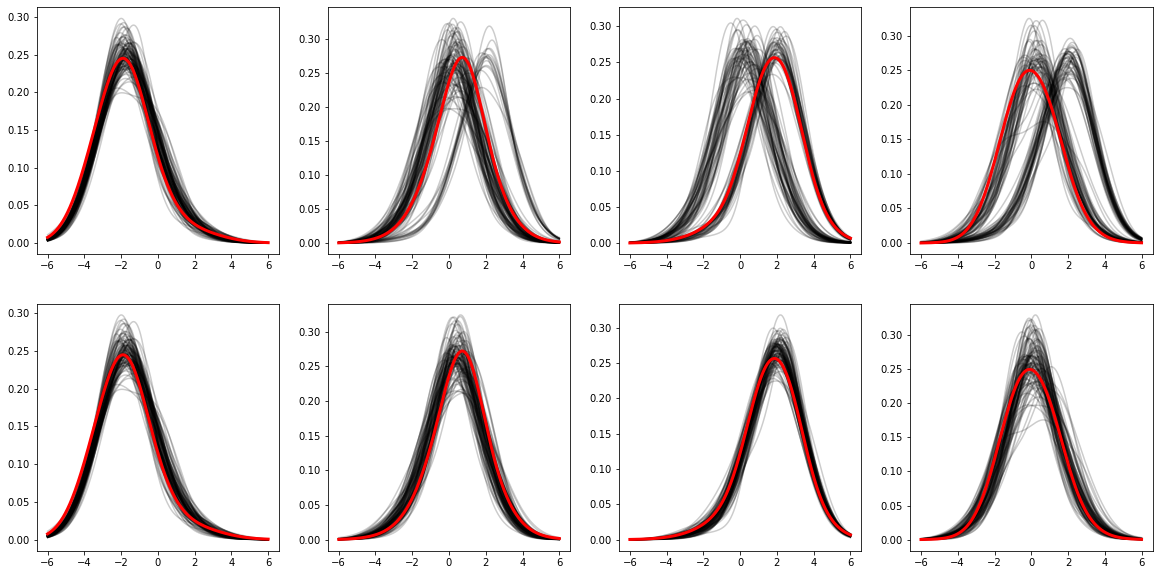

In [186]:
idx = np.arange(1, 1000, 10)

fig, axes = plt.subplots(nrows=2, ncols=int(nlat), figsize=(20, 10))

for j in sorted(idx)[:-1]:
    state = onp.array(states)[np.arange(0, 10000, 10)][j]
    q = qs[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    
    dens_lat = eval_comps[:, np.newaxis, :] * (q @ state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T  
    dens_lat = dens_lat / (np.sum(dens_lat, axis=1, keepdims=True) * delta)
    
    aligned_lat = align(template_dens, dens_lat)
    
    for i in range(nlat):
            axes[0][i].plot(xgrid, dens_lat[i, :], color="black", alpha=0.2)
            axes[1][i].plot(xgrid, aligned_lat[i, :], color="black", alpha=0.2)
            
            
for i in range(nlat):
    axes[0][i].plot(xgrid, template_dens[i, :], color="red", lw=3)
    axes[1][i].plot(xgrid, template_dens[i, :], color="red", lw=3)
    
# plt.savefig("../latex/images/simu_mgp_latent_dens.pdf", bbox_inches="tight")

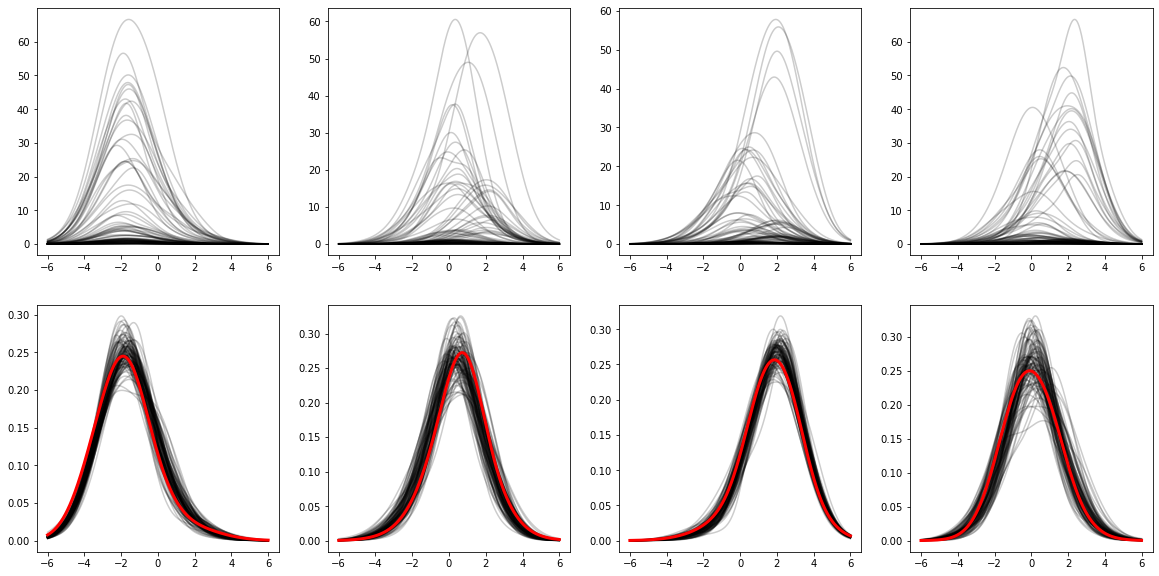

In [196]:
idx = np.arange(1, 1000, 10)

fig, axes = plt.subplots(nrows=2, ncols=int(nlat), figsize=(20, 10))

for j in sorted(idx)[:-1]:
    state = onp.array(states)[np.arange(0, 10000, 10)][j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    
    j = state.j * 1e20
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T  
    
    norm_dens_lat = dens_lat / (np.sum(dens_lat, axis=1, keepdims=True) * delta)
    
    aligned_lat = align(template_dens, norm_dens_lat)
    
    for i in range(nlat):
            axes[0][i].plot(xgrid, dens_lat[i, :], color="black", alpha=0.2)
            axes[1][i].plot(xgrid, aligned_lat[i, :], color="black", alpha=0.2)
            
            
for i in range(nlat):
    axes[1][i].plot(xgrid, template_dens[i, :], color="red", lw=3)
    
#plt.savefig("../latex/images/simu_mgp_latent_dens.pdf", bbox_inches="tight")

In [194]:
jsum = np.array([np.sum(x.j) for x in states])
np.min(jsum)

DeviceArray(4.16826467e-21, dtype=float64)